STEP-1 Installing required libraries

In [1]:
#required packages version for tensorflow and keras
%pip install tensorflow==1.13.1
!pip install keras==2.1.0

     |████████████████████████████████| 92.5MB 59kB/s 
     |████████████████████████████████| 368kB 39.2MB/s 
     |████████████████████████████████| 3.2MB 51.7MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0
     |████████████████████████████████| 307kB 4.5MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


STEP-02 Adding required libraries

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import keras
import os, argparse
import cv2, spacy, numpy as np
from keras.layers import Input, LSTM, Embedding, Dense
from keras.applications.vgg16 import VGG16
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.externals import joblib
from keras import backend as K
from keras.utils.vis_utils import plot_model
K.set_image_data_format('channels_first')
import csv
#mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Mounted at /content/drive


STEP-03 Loading pre-trained VGG-16

In [11]:
from keras.preprocessing import image
from keras.applications import vgg16
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
model = vgg16.VGG16(weights='imagenet', include_top=True)
from keras.utils import plot_model

In [4]:
model = vgg16.VGG16(weights='imagenet', include_top=True)

STEP-04 Defining functions for VQA model

In [5]:
def get_image_features_without_fd(image_file_name,model):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    img = image.load_img(image_file_name, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    model_extractfeatures = Model(input=model.input, output=model.get_layer('fc2').output)
    fc2_features = model_extractfeatures.predict(x)
    image_features = fc2_features.reshape(4096)
    return image_features

In [6]:
def get_image_model_without():
    ''' Takes the CNN weights file, and returns the VGG model update 
    with the weights. Requires the file VGG.py inside models/CNN '''
    image_model = VGG16(weights='imagenet', include_top=False)
    image_model.layers.pop()
    image_model.layers.pop()
    # this is standard VGG 16 without the last two layers
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # one may experiment with "adam" optimizer, but the loss function for
    # this kind of task is pretty standard
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model

In [7]:
vgg_without = get_image_model_without()

58892288/58889256 [==============================] - 1s 0us/step
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
def get_question_features_without_fd(question):
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    word_embeddings = spacy.load('en_core_web_md')
    tokens = word_embeddings(question)
    question_tensor = np.zeros((30, 300))
    for j in range(len(tokens)):
        question_tensor[j,:] = tokens[j].vector
    return question_tensor

In [17]:

def get_image_features_without_fd(image_file_name,model):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    img = image.load_img(image_file_name, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    model_extractfeatures = Model(input=model.input, output=model.get_layer('fc2').output)
    fc2_features = model_extractfeatures.predict(x)
    image_features = fc2_features.reshape(4096)
    return image_features

In [18]:
def get_VQA_model():
    ''' Given the VQA model and its weights, compiles and returns the model '''

    # thanks the keras function for loading a model from JSON, this becomes
    # very easy to understand and work. Alternative would be to load model
    # from binary like cPickle but then model would be obfuscated to users
    vqa_model = model_from_json(open("/content/drive/MyDrive/latest_vqa/our_model_final.json").read())
    # vqa_model.load_weights(VQA_weights_file_name)
    vqa_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return vqa_model

In [19]:
our_vqa_model = get_VQA_model()
our_vqa_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_2 (Merge)              (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
activation_5 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_6 (Activation)    (None, 1024)              0         
___________________________

In [20]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.1MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051304 sha256=543e5dc20ecdc3f9d1988025e5472355a27e389d84642c15939a0cb9916abea5
  Stored in directory: /tmp/pip-ephem-wheel-cache-s7rl83gb/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:

import spacy.cli
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
word_embeddings = spacy.load('en_core_web_md')

In [ ]:

def get_question_features_without_fd(question,word_embeddings):
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    tokens = word_embeddings(question)
    question_tensor = np.zeros((30, 300))
    for j in range(len(tokens)):
        question_tensor[j,:] = tokens[j].vector
    return question_tensor

In [ ]:
def create_image_feature_test(image_path,model):
  image_features = get_image_features_without_fd(image_path,model)
  image_feature_processed = np.array(image_features)
  image_feature_processed = image_feature_processed.reshape((1,image_feature_processed.shape[0]))
  return image_feature_processed

In [ ]:
new_image = create_image_feature_test('/content/drive/MyDrive/latest_vqa/sample_data/8.jpg',model)

In [ ]:
new_image.shape

(1, 4096)

In [ ]:
def create_question_feature_test(text):
  question_feature=get_question_features_without_fd(text,word_embeddings)
  question_feature_processed = np.array(question_feature)  
  question_feature_processed = question_feature_processed.reshape((1,question_feature_processed.shape[0], question_feature_processed.shape[1]))
  return question_feature_processed

In [ ]:
training_datas = []
with open('/content/drive/MyDrive/latest_vqa/sample_data/training.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  for row in csv_reader:
    training_datas.append(row)
training_datas = training_datas[1:]
len(training_datas)

65

In [ ]:
trainY= []
for training_data in training_datas:
  img_id,text,output = training_data
  trainY.append(output)
print(len(trainY))
print(trainY)

65
['yes', 'hand', 'hand', 'single', 'multiple', 'hand', 'yes', 'foreign', 'yes', 'yes', 'foreign', 'hand', 'yes', 'skull', 'skull', 'skull', 'skull', 'hand', 'left', 'left', 'right', 'left', 'right', 'right', 'right', 'right', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'yes', 'yes', 'foreign', 'foreign', 'foreign', 'foreign', 'foreign', 'leg', 'leg', 'leg', 'leg', 'leg', 'leg', 'leg', 'single', 'yes', 'yes', 'multiple', 'multiple', 'multiple', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes']


In [ ]:
set_trainy = list(set(trainY))
trainY_labels = []
for y in trainY:
  trainY_labels.append(set_trainy.index(y))
print(trainY_labels)

[2, 1, 1, 9, 4, 1, 2, 5, 2, 2, 5, 1, 2, 0, 0, 0, 0, 1, 6, 6, 3, 6, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 9, 2, 2, 4, 4, 4, 7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 2]


In [ ]:
trainY_cate = keras.utils.to_categorical(trainY_labels, num_classes=10)

In [ ]:
trainX= []
for training_data in training_datas:
  img_id,text,output = training_data
  print("Processing {} image".format(img_id))
  image_features = get_image_features_without_fd("/content/drive/MyDrive/latest_vqa/sample_data/{}.jpg".format(img_id),model)
  question_features = get_question_features_without_fd(text,word_embeddings)
  trainX.append([question_features,image_features])
np.array(trainX).shape

Processing 1 image
Processing 1 image
Processing 2 image
Processing 2 image
Processing 3 image
Processing 3 image
Processing 4 image
Processing 4 image
Processing 5 image
Processing 6 image
Processing 6 image
Processing 7 image
Processing 7 image
Processing 8 image
Processing 9 image
Processing 10 image
Processing 11 image
Processing 12 image
Processing 13 image
Processing 14 image
Processing 15 image
Processing 16 image
Processing 17 image
Processing 18 image
Processing 19 image
Processing 20 image
Processing 21 image
Processing 22 image
Processing 23 image
Processing 24 image
Processing 25 image
Processing 26 image
Processing 27 image
Processing 28 image
Processing 29 image
Processing 30 image
Processing 31 image
Processing 32 image
Processing 33 image
Processing 34 image
Processing 35 image
Processing 36 image
Processing 37 image
Processing 38 image
Processing 39 image
Processing 40 image
Processing 41 image
Processing 42 image
Processing 42 image
Processing 42 image
Processing 43 i

(65, 2)

In [ ]:
question_features_array = []
image_features_array = []
for x in trainX:
  question_features_array.append(x[0])
  image_features_array.append(x[1])

In [ ]:
question_features_array = np.array(question_features_array)
image_features_array = np.array(image_features_array)
print(question_features_array.shape)
print(image_features_array.shape)

(65, 30, 300)
(65, 4096)


In [ ]:
trainY= []
for training_data in training_datas:
  img_id,text,output = training_data
  trainY.append(output)
print(len(trainY))
print(trainY)

65
['yes', 'hand', 'hand', 'single', 'multiple', 'hand', 'yes', 'foreign', 'yes', 'yes', 'foreign', 'hand', 'yes', 'skull', 'skull', 'skull', 'skull', 'hand', 'left', 'left', 'right', 'left', 'right', 'right', 'right', 'right', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'yes', 'yes', 'foreign', 'foreign', 'foreign', 'foreign', 'foreign', 'leg', 'leg', 'leg', 'leg', 'leg', 'leg', 'leg', 'single', 'yes', 'yes', 'multiple', 'multiple', 'multiple', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes']


In [ ]:
set_trainy = list(set(trainY))
trainY_labels = []
for y in trainY:
  trainY_labels.append(set_trainy.index(y))
print(trainY_labels)

[2, 1, 1, 9, 4, 1, 2, 5, 2, 2, 5, 1, 2, 0, 0, 0, 0, 1, 6, 6, 3, 6, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 9, 2, 2, 4, 4, 4, 7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 2]


In [ ]:
trainY_cate = keras.utils.to_categorical(trainY_labels, num_classes=10)

In [ ]:
history = our_vqa_model.fit([question_features_array,image_features_array],trainY_cate,5,30)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
65/65 [==============================] - 17s 261ms/step - loss: 6.7750
Epoch 2/30
65/65 [==============================] - 14s 210ms/step - loss: 3.9690
Epoch 3/30
65/65 [==============================] - 14s 210ms/step - loss: 3.4932
Epoch 4/30
65/65 [==============================] - 14s 209ms/step - loss: 3.5266
Epoch 5/30
65/65 [==============================] - 13s 207ms/step - loss: 2.7419
Epoch 6/30
65/65 [==============================] - 13s 206ms/step - loss: 3.3405
Epoch 7/30
65/65 [==============================] - 13s 200ms/step - loss: 2.7904
Epoch 8/30
65/65 [==============================] - 13s 199ms/step - loss: 2.5609
Epoch 9/30
65/65 [==============================] - 13s 200ms/step - loss: 2.4415
Epoch 10/30
65/65 [==============================] - 13s 199ms/step - loss: 2.9312
Epoch 11/30
65/65 [==============================] - 13s 202ms/step - loss: 2.4189
Epoch 12/30
65/65 [=============================

In [ ]:
our_vqa_model.save_weights('/content/model_weights_after_training.h5')

# Save the model architecture
with open('/content/model_architecture_after_training.json', 'w') as f:
    f.write(our_vqa_model.to_json())

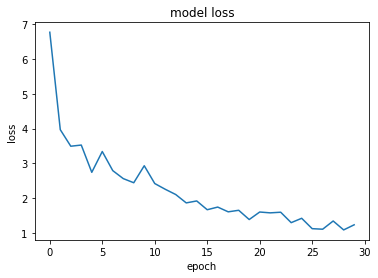

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
with open('/content/model_architecture_after_training.json', 'r') as f:
    vqa_model = model_from_json(f.read())

# Load weights into the new model
vqa_model.load_weights('/content/model_weights_after_training.h5')

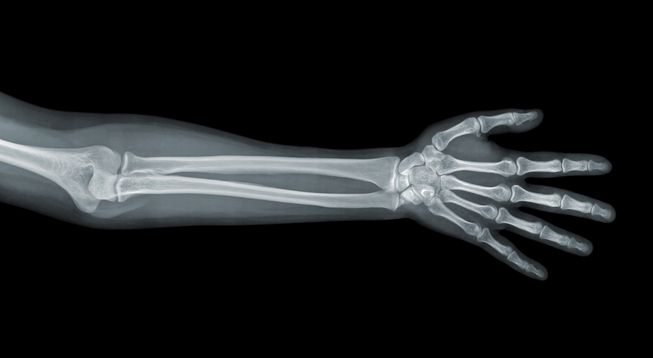

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/latest_vqa/sample_data/test/healthyhand.jpg')

In [ ]:
new_question = create_question_feature_test("is this left or right")

In [ ]:
new_image = create_image_feature_test('/content/drive/MyDrive/latest_vqa/sample_data/test/healthyhand.jpg',model)

In [ ]:
result=set_trainy[vqa_model.predict_classes([new_question,new_image])[0]]


1/1 [==============================] - 1s 552ms/step


In [ ]:
print(result)

left


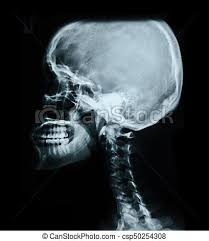

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/latest_vqa/sample_data/11.jpg')

In [ ]:
new_question = create_question_feature_test("what is the body part")

In [ ]:
new_image = create_image_feature_test('/content/drive/MyDrive/latest_vqa/sample_data/11.jpg',model)

In [ ]:
result=set_trainy[vqa_model.predict_classes([new_question,new_image])[0]]


1/1 [==============================] - 0s 69ms/step


In [ ]:
print(result)

skull


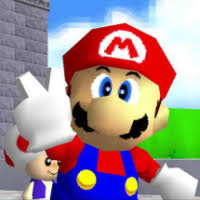

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/latest_vqa/sample_data/47.jpg')

In [ ]:
new_question = create_question_feature_test("is this xray")

In [ ]:
new_image = create_image_feature_test('/content/drive/MyDrive/latest_vqa/sample_data/47.jpg',model)

In [ ]:
result=set_trainy[vqa_model.predict_classes([new_question,new_image])[0]]


1/1 [==============================] - 0s 60ms/step


In [ ]:
print(result)

no
